In [1]:
# Import my packages.
import flymovie as fm
import os
import copy
import scipy
import skimage as ski
import scipy.ndimage as ndi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Activate package autoload.
%load_ext autoreload
%autoreload 2

In [2]:
sys.path

['/Users/michaelstadler/Bioinformatics/Projects/rpb1/notebooks_active',
 '/Users/michaelstadler/.vscode/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles',
 '/Users/michaelstadler/.vscode/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles/lib/python',
 '/Users/michaelstadler/opt/anaconda3/envs/im/lib/python38.zip',
 '/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8',
 '/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8/lib-dynload',
 '',
 '/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8/site-packages',
 '/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8/site-packages/aeosa',
 '/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin',
 '/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8/site-packages/IPython/extensions',
 '/Users/michaelstadler/.ipython']

## Tasks
- Remove HLB


In [2]:
# Functions

@dataclass
class BlobStack:
    '''Class for keeping track of Blob stack processing.'''
    filepath: str
    stack: np.ndarray
    nucmask: np.ndarray
    blobmask: np.ndarray
    spot_counts: np.array

def count_spots_fromfits(fits_filtered, nucmask):
    nuc_ids = np.unique(nucmask)
    spot_counts = np.zeros(len(nuc_ids))

    for row in fits_filtered[0]:
        coords = row[0:3]
        coords = tuple([int(x) for x in coords])
        nuc_id = nucmask[coords]
        spot_counts[nuc_id] += 1

    return spot_counts

def count_spots_frommask(labelmask, nucmask):
    nuc_ids = np.unique(nucmask)
    spot_counts = np.zeros(len(nuc_ids))
    props = ski.measure.regionprops(labelmask)
    for id_ in range(0, len(props)):
        centroid = tuple([int(x) for x in props[id_].centroid])
        nuc_id = nucmask[centroid]
        spot_counts[nuc_id] += 1
    return spot_counts

def find_thresh(im, nucmask):
    for t in range(0, 25):
        mask = np.where(nucmask & (im > t), 1, 0)
        mask = ndi.morphology.binary_opening(mask, structure=np.ones((1,2,2)))
        lmask, _ = ndi.label(mask)
        labels, counts = np.unique(lmask, return_counts=True)
        pct10, pct90 = np.percentile(counts, [10,60])
        counts = counts[(counts >= pct10) & (counts <= pct90)]
        print(t, len(np.unique(lmask)), np.mean(counts))

def remove_edge_nuclei(nucmask, max_edge_pixels=0):
    new_mask = nucmask.copy()
    for nuc_id in np.unique(nucmask):
        z, i, j = np.where(nucmask == nuc_id)
        edgecount_i = np.count_nonzero(i == 0) + np.count_nonzero(i == (nucmask.shape[1] - 1))
        edgecount_j = np.count_nonzero(j == 0) + np.count_nonzero(j == (nucmask.shape[2] - 1))
        if ((edgecount_i + edgecount_j) > max_edge_pixels):
            new_mask[new_mask == nuc_id] = 0
    return new_mask



In [3]:
data = []

In [4]:
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 10/embryo 5.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 10/emb 23.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 11/embryo9b.czi'
filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 11/embryo11b.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 11/embryo15.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 11/embryo22.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 11/embryo36.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 12/embryo3.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 12/embryo6.czi'
#filepath = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/counting_blobs/cycle 12/embryo17.czi'

stack = fm.read_czi(filepath, swapaxes=False)

## Make nuclear mask

In [5]:
fm.viewer(stack, 6, zmax=True)
#fm.viewer(stack, 6)

interactive(children=(Dropdown(description='Color', index=10, options=('Greens', 'prism', 'Reds', 'viridis', '…

In [6]:
nuc = fm.segment_nuclei_3Dstack_rpb1(stack, min_nuc_center_dist=65, sigma=5)

In [7]:
# nc11: 75000, 350000
nuc2 = fm.labelmask_filter_objsize(nuc, 85000, 350000)
fm.viewer(nuc2.max(axis=0), 6)

interactive(children=(Dropdown(description='Color', index=10, options=('Greens', 'prism', 'Reds', 'viridis', '…

In [8]:
nuc3 = remove_edge_nuclei(nuc2)
nuc4 = fm.labelmask_apply_morphology(nuc3, ndi.morphology.binary_dilation, struct=np.ones((1,14,14)), expand_size=(2,15,15))
fm.viewer(np.where(nuc3, stack, 0), 6)

interactive(children=(Dropdown(description='Color', index=10, options=('Greens', 'prism', 'Reds', 'viridis', '…

In [9]:
nucmask = fm.relabel_labelmask(nuc4)

## Segment blobs, count

In [10]:
# Perform DoG filtering.
sigma_big = 20
sigma_small = 0.5

channel=0
stack3d = stack.astype('uint16')
stack4d = np.expand_dims(stack3d, 0)
stack5d = np.expand_dims(stack4d, 0)

dog = fm.dog_filter(stack3d, [0,sigma_small,sigma_small],[0,sigma_big,sigma_big])
fm.viewer(dog, 6, init_minval=0)

interactive(children=(Dropdown(description='Color', index=8, options=('gray', 'gray_r', 'inferno', 'Reds', 'Gr…

In [ ]:
find_thresh(dog, nucmask)

In [79]:
# Pick a slice near the middle and determine a reasonable threshold for it.
ref_slice = 20
ref_thresh = 16
test_im = ndi.morphology.binary_opening(np.where(dog[ref_slice] >= ref_thresh, 1, 0), structure=np.ones((2,2)))
#test_im = np.where(dog[ref_slice] >= ref_thresh, 1, 0)
fm.viewer(np.where(test_im, 1, 0), 6)

interactive(children=(Dropdown(description='Color', index=8, options=('gray', 'gray_r', 'inferno', 'Reds', 'Gr…

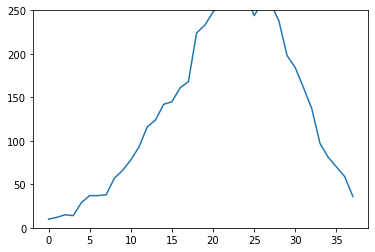

In [80]:
mask = fm.threshold_w_slope(dog, ref_thresh, 18, -0.05, display=True, ymax=250)[0]

In [154]:
# Perform 3D gaussian fitting on each object in the binary mask.
mask4d = np.expand_dims(mask, axis=0)
dog4d = np.expand_dims(dog, axis=0) - np.min(dog)
fits6 = fm.fit_objects_from_mask(stack4d, mask4d, fitwindow_rad_z=1, fitwindow_rad_xy=6)
#fm.quickview_ms2(stack5d, fits, MAX=False, shadows=False, halfwidth_z=0, figsize=6)

0
# to fit: 3341
# fit:  1000 2000 3000 

In [155]:
def new_filter(fits, x):
    scores = np.log((fits[:,4] * (2**8)) / fits[:,5])/np.log(2)
    return fits[scores >= x,:]
    #return scores

test5 = new_filter(fits5[0], -np.inf)
test6 = new_filter(fits6[0], -1000)
test7 = new_filter(fits7[0], -np.inf)
test8 = new_filter(fits8[0], -1000)

In [156]:
def highlight(stack, mask, fits_filtered):
    hl_stack = stack.copy() * 0.75
    hl_value = 2 * np.max(stack)
    for rownum in range(0, fits_filtered.shape[0]):
        """
        coords = tuple([int(x) for x in fits_filtered[rownum, :3]])
        print(coords, end = '')
        obj_id = labelmask[coords]
        if obj_id != 0:
            good_ids.append(obj_id)
        else:
            print("heyo",)
        """
        z, i, j = tuple([int(x) for x in fits_filtered[rownum, :3]])
        for i_ in range((i-1),(i+2)):
            for j_ in range((j-1),(j+2)):
                try:
                    hl_stack[(z,i_,j_)] = hl_value
                except:
                    pass
    return hl_stack
        
highlights = highlight(stack, mask, test6)
#highlights = np.where(mask, np.max(stack) * 2, stack)
fm.viewer([stack, highlights], 12)



interactive(children=(Dropdown(description='Color', index=8, options=('gray', 'gray_r', 'inferno', 'Reds', 'Gr…

In [132]:
lm, _ = ndi.label(mask)


In [144]:
mask[37, 527, 78]

False

In [136]:
fm.viewer(lm,6)

interactive(children=(Dropdown(description='Color', index=8, options=('gray', 'gray_r', 'inferno', 'Reds', 'Gr…

In [119]:
fm.viewer(mask,6)

interactive(children=(Dropdown(description='Color', index=8, options=('gray', 'gray_r', 'inferno', 'Reds', 'Gr…

In [63]:
labelmask, _ = ndi.label(mask)
fm.viewer(labelmask, 6)

interactive(children=(Dropdown(description='Color', options=('cividis', 'Gators', 'inferno', 'Reds', 'magma', …

In [64]:
# Count spots per nucleus
spot_counts = count_spots_frommask(labelmask, nucmask)
print(np.mean(spot_counts[1:]))
spot_counts

233.8181818181818


array([1211.,  269.,  274.,  243.,  236.,  213.,  220.,  187.,  274.,
        236.,  216.,  204.])

In [65]:
blobdata = BlobStack(filepath, stack, nucmask, labelmask, spot_counts)

In [66]:
data.append(blobdata)
del spot_counts, blobdata, nucmask, mask, labelmask, nuc, nuc2, nuc3, stack


In [71]:
np.mean(data[3].spot_counts[1:])

233.8181818181818

In [ ]:
means_ = []
for n in range(0, 3):
    mean_ = np.mean(data[n].stack[data[n].nucmask.astype('bool')])
    means_.append(mean_)
plt.plot(means_)

medians = []
for n in range(0, 3):
    median_ = np.median(data[n].stack[data[n].nucmask.astype('bool')])
    medians.append(median_)
plt.plot(medians)

In [72]:
fm.viewer([data[2].stack, data[3].stack], 8)

interactive(children=(Dropdown(description='Color', options=('cividis', 'Gators', 'inferno', 'Reds', 'magma', …

In [ ]:
for n in range(0,3):
    print(np.mean(data[n].spot_counts[1:]))

In [ ]:
fm.save_pickle(data, '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210813-rpb1blobdata.pkl')

In [ ]:
"""
# Perform 3D gaussian fitting on each object in the binary mask.
fits = fm.fit_objects_from_mask(stack4d, mask, fitwindow_rad_z=1, fitwindow_rad_xy=3)
fm.quickview_ms2(stack5d, fits, MAX=False, shadows=False, halfwidth_z=0, figsize=6)
"""

In [ ]:
"""
# Filter spots based on fit parameters, get spot-centered stacks, organized by z slice.
peakiness = 0
fits_filtered = fm.filter_ms2fits(fits, peakiness, stack)
fm.quickview_ms2(stack5d, fits_filtered, MAX=False, shadows=False, halfwidth_z=0, figsize=6)
"""

nc11: embryo 9b, 11, 11b, 12

I think a reasonable thing to do (if we can take data with high consistency) is to call spots just using a consistent threshold (perhaps adjusted for some kind of normalizing factor). I'd also like a principled way to doing thresholding. I wonder about the idea of using segmented object size to threshold? Also, need to eliminate HLB.

In [ ]:
from skimage.filters import threshold_otsu
threshold_otsu(dog[nucmask > 0])

In [ ]:
fm.viewer(dog)

In [ ]:
plt.hist(dog[(nucmask > 0) & (dog > 0)], range=(0,100), bins=100);

In [ ]:
for t in range(10,20):
    vals = dog_t[nucmask_t.astype('bool')]
    print(t, np.std(vals[vals >= t]), np.std(vals[vals < t]))

In [ ]:
test = stack[19]
series = np.expand_dims(test.copy(), axis=0)
#series = test.copy()
for x in range(1,50):
    sigma_small=0.5
    sigma_big=x
    dog_t = fm.dog_filter(test, [sigma_small,sigma_small],[sigma_big,sigma_big])
    series = np.vstack([series, np.expand_dims(dog_t, axis=0)])



In [174]:
bg_stack = np.random.normal(20, 3, size=stack.shape)
bg = np.where(nucmask, bg_stack, 0)

Params:
- background mean
- background var
- blob intensity mean 
- blob instensity var
- blob number
- blob radius mean
- blob radius var

In [144]:
from flymovie.fitting import gaussian3d

def make_3d_gauss_box(intensity, sigma_z, sigma_ij, z_winlen, ij_winlen):
    d1 = scipy.signal.gaussian(ij_winlen, sigma_ij)
    d2 = np.outer(d1, d1)
    z_1dvector = scipy.signal.gaussian(z_winlen, sigma_z)
    d3 = d2 * np.expand_dims(z_1dvector, axis=(1,2))
    return intensity * d3

bg_mean = 20
bg_sd = 2
def simulate(nucmask, bg_mean, bg_var, blob_intensity_mean, blob_intensity_var, blob_radius_mean, blob_radius_var, blob_number):
    def add_box(stack, box, coords):
        box_starts = []
        box_ends = []
        stack_starts = []
        stack_ends = []
        for dim in range(0, 3):
            start = coords[dim] - int(box.shape[dim] / 2)
            end = coords[dim] + int(box.shape[dim] / 2) + 1
            if start < 0:
                stack_starts.append(0)
                stack_ends.append(end + start)
                box_starts.append(-start)
                box_ends.append(box.shape[dim] + start)
            elif end > stack.shape[dim]:
                stack_starts.append(start)
                stack_ends.append(stack.shape[dim])
                box_starts.append(0)
                box_ends.append(box.shape[dim] + stack.shape[dim] - end)
            else:
                stack_starts.append(start)
                stack_ends.append(end)
                box_starts.append(0)
                box_ends.append(box.shape[dim])
        #box_to_add = box[box_starts[0]:box_ends[0], box_starts[1]:box_ends[1], box_starts[1]:box_ends[1]]
        #stack[stack_starts[0]:stack_ends[0], stack_starts[1]:stack_ends[1], stack_starts[1]:stack_ends[1]] += box_to_add
        #print(stack[stack_starts[0]:stack_ends[0], stack_starts[1]:stack_ends[1], stack_starts[1]:stack_ends[1]].shape)
        #print(box[box_starts[0]:box_ends[0], box_starts[1]:box_ends[1], box_starts[1]:box_ends[1]].shape)
        #print(stack_starts)
        stackshape = stack[stack_starts[0]:stack_ends[0], stack_starts[1]:stack_ends[1], stack_starts[1]:stack_ends[1]].shape
        boxshape = box[box_starts[0]:box_ends[0], box_starts[1]:box_ends[1], box_starts[1]:box_ends[1]].shape
        if stackshape == boxshape:
            box_to_add = box[box_starts[0]:box_ends[0], box_starts[1]:box_ends[1], box_starts[2]:box_ends[2]]
            stack[stack_starts[0]:stack_ends[0], stack_starts[1]:stack_ends[1], stack_starts[2]:stack_ends[2]] += box_to_add
        else:
            print('holla')

    # Must be odd
    z_windowlen = 5
    ij_windowlen = 21
    bg_stack = np.random.normal(bg_mean, bg_var, size=nucmask.shape)
    simstack = np.where(nucmask, bg_stack, 0)
    for nuc_id in np.unique(nucmask)[1:]:
    #for nuc_id in range(0,1):
        nuc_coords = np.where(nucmask == nuc_id)
        nuc_numpixels = len(nuc_coords[0])
        for n in range(0, blob_number):
            r_ij = np.random.normal(blob_radius_mean, blob_radius_var)
            r_z = r_ij / 2
            intensity = np.random.normal(blob_intensity_mean, blob_intensity_var)
            
            rand_pixel_num = np.random.randint(0, nuc_numpixels - 1)
            z, i, j = nuc_coords[0][rand_pixel_num], nuc_coords[1][rand_pixel_num], nuc_coords[2][rand_pixel_num]
            gaussian_function = gaussian3d(z, i, j, intensity, r_z, r_ij, r_ij)
            box = make_3d_gauss_box(intensity, r_z, r_ij, z_windowlen, ij_windowlen)
            add_box(simstack, box, (z, i, j))
    return simstack            
    


In [161]:
sim = simulate(nuc2, bg_mean=28, bg_var=9, blob_intensity_mean=35, blob_intensity_var=3, blob_radius_mean=1, blob_radius_var=0.8, blob_number=250)
b = np.where(nuc2, sim, stack)
fm.viewer(b, 6)

interactive(children=(Dropdown(description='Color', index=10, options=('Greens', 'prism', 'Reds', 'viridis', '…

In [159]:
fm.viewer(stack, 6)

interactive(children=(Dropdown(description='Color', index=10, options=('Greens', 'prism', 'Reds', 'viridis', '…

In [ ]:
5/10000